# Inference for ArcFace models

## Overview

This notebook can be used for inference on ArcFace ONNX models. The demo shows how to use the trained models to do inference in MXNet.


## Prerequisites

The following packages need to be installed before proceeding:

* MXNet - `pip install mxnet`
* numpy - `1pip install numpy`
* matplotlib - `pip install matplotlib`
* OpenCV - `pip install opencv-python`
* Graphviz - `pip install graphviz`


## Import dependencies
Verify that all dependencies are installed using the cell below. Continue if no errors encountered, warnings can be ignored.

In [1]:
import cv2
import sys
import numpy as np
import mxnet as mx
import os
from __future__ import print_function

%matplotlib inline
from matplotlib import pyplot as plt

## Load pretrained model

`get_model()` : Loads ONNX model into MXNet symbols and params, defines model using symbol file and binds parameters to the model using params file.

In [2]:
def get_model(ctx, image_size, model_str, layer):
    _vec = model_str.split(',')
    assert len(_vec)==2
    prefix = _vec[0]
    epoch = int(_vec[1])
    print('loading',prefix, epoch)
    sym, arg_params, aux_params = mx.model.load_checkpoint(prefix, epoch)
    all_layers = sym.get_internals()
    sym = all_layers[layer+'_output']
    model = mx.mod.Module(symbol=sym, context=ctx, label_names = None)
    model.bind(data_shapes=[('data', (1, 3, image_size[0], image_size[1]))])
    model.set_params(arg_params, aux_params)
    return model, sym

## Preprocess images

In order to input only face pixels into the network, all input images are passed through a pretrained face detection and alignment model as described above. The output of this model are landmark points and a bounding box corresponding to the face in the image. Using this output, the image is processed using affine transforms to generate the aligned face images which are input to the network. The functions performing this is defined below.

`get_input()` : Returns aligned face to the bbox and margin

In [3]:
def get_input(img, image_size, bbox=None, margin=44):
    if bbox is None:
        det = np.zeros(4, dtype=np.int32)
        det[0] = int(img.shape[1]*0.0625)
        det[1] = int(img.shape[0]*0.0625)
        det[2] = img.shape[1] - det[0]
        det[3] = img.shape[0] - det[1]
    else:
        det = bbox
    bb = np.zeros(4, dtype=np.int32)
    bb[0] = np.maximum(det[0]-margin/2, 0)
    bb[1] = np.maximum(det[1]-margin/2, 0)
    bb[2] = np.minimum(det[2]+margin/2, img.shape[1])
    bb[3] = np.minimum(det[3]+margin/2, img.shape[0])
    img = img[bb[1]:bb[3],bb[0]:bb[2],:]
    img = cv2.resize(img, (image_size[1], image_size[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    aligned = np.transpose(img, (2,0,1))
    return aligned

## Predict
`get_feature()` : Performs forward pass on the data aligned using model and returns the embedding

In [4]:
def l2_normalize(X):
    norms = np.sqrt((X * X).sum(axis=1))
    X /= norms[:, np.newaxis]
    return X

def get_feature(model,aligned):
    input_blob = np.expand_dims(aligned, axis=0)
    data = mx.nd.array(input_blob)
    db = mx.io.DataBatch(data=(data,))
    model.forward(db, is_train=False)
    embedding = model.get_outputs()[0].asnumpy()
    embedding = l2_normalize(embedding).flatten()
    return embedding

## Demo

Load the model on the cpu, then compare badge image images to an aligned image

In [5]:
%%time

image_size = (112,112)
model_name = '../models/mobilenet1,0'
model, sym = get_model(mx.cpu(), image_size, model_name, 'fc1')

loading ../models/mobilenet1 0
CPU times: user 117 ms, sys: 21.5 ms, total: 138 ms
Wall time: 121 ms


In [6]:
# Plot the model
mx.viz.plot_network(sym)

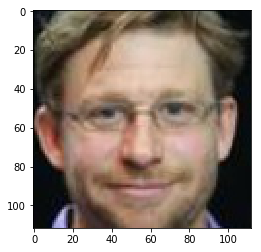

In [7]:
img1 = cv2.imread('people/julbrigh.jpg')
pre1 = get_input(img1, image_size)
plt.imshow(np.transpose(pre1,(1,2,0)))

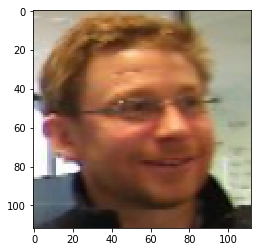

In [8]:
img2 = cv2.imread('people/julbrigh_test.jpg')
bbox = [30,60,80,100] 
margin = 44
pre2 = get_input(img2, image_size, bbox, margin)
plt.imshow(np.transpose(pre2,(1,2,0)))

## Generate predictions

Two face images are passed through the network sequentially to generate embedding vectors for each. 

In [9]:
# given the model 
out1 = get_feature(model,pre1)
out2 = get_feature(model,pre2)

In [10]:
%timeit get_feature(model,pre1)

23.8 ms ± 3.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Calculate similarity

he squared distance and cosine similarity between the embedding vectors are computed and displayed. Images containing face of a single person will have low distance and high similarity and vice-versa. The distance values are in [0,4) and similarity values in [-1,1].

In [11]:
# Compute squared distance between embeddings
dist = np.sum(np.square(out2-out1))
# Compute cosine similarity between embedddings
sim = np.dot(out1, out2.T)
# Print predictions
print('Distance = %f' %(dist))
print('Similarity = %f' %(sim))

Distance = 0.982107
Similarity = 0.508946


## Plot Distribution

Load the saved vectors for all people in the database, and plot the distribution and outliner for match.

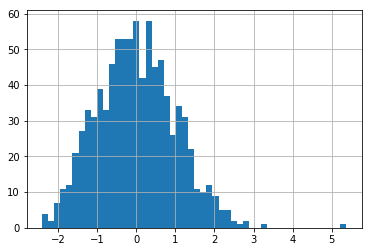

In [12]:
from scipy import stats
import pandas as pd

# Load saved vectors
vecs = np.load('../models/people.npz')['vecs']
sims = np.dot(vecs, out2)
sim = sims[sims.argmax()]
z_score = (sim - sims.mean()) / sims.std()
pd.Series(stats.zscore(sims)).hist(bins=50)